In [1]:
# https://medium.com/analytics-vidhya/covid-19-tweets-geographical-and-sentiment-analysis-c33b4aa5b777

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import string
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
import requests
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm import tqdm, notebook
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [6]:
df = pd.read_csv(r'../Data/covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


<h1> Exploration  Analysis (EDA)</h1>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
user_name           179108 non-null object
user_location       142337 non-null object
user_description    168822 non-null object
user_created        179108 non-null object
user_followers      179108 non-null int64
user_friends        179108 non-null int64
user_favourites     179108 non-null int64
user_verified       179108 non-null bool
date                179108 non-null object
text                179108 non-null object
hashtags            127774 non-null object
source              179031 non-null object
is_retweet          179108 non-null bool
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [8]:
# Date range
df.date.min(), df.date.max()

('2020-07-24 23:47:08', '2020-08-30 09:07:39')

In [9]:
# rewtweet counts
df['is_retweet'].value_counts() # there is no retweets

False    179108
Name: is_retweet, dtype: int64

In [12]:
# tweets of verified users
df['user_verified'].value_counts(normalize=True)

False    0.871055
True     0.128945
Name: user_verified, dtype: float64

In [13]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


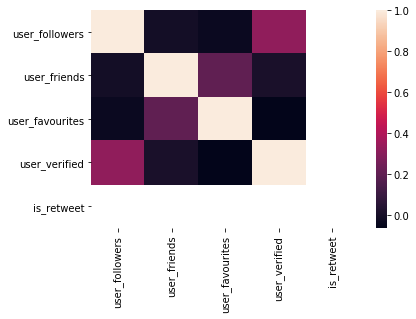

In [14]:
#heat map of correlation
sns.heatmap(df.corr())

<h3> Detailed Analysis </h3>

In [15]:
# make a copy of the data frame
tweets = df.copy()

In [16]:
# convert date columns to datetime objects
tweets['date']= pd.to_datetime(tweets['date'])
tweets['user_created']=pd.to_datetime(tweets['user_created'])
tweets['date_ext'] = tweets['date'].dt.date

In [17]:
# fill None
tweets.user_location.fillna('Unknown', inplace=True)
tweets.user_description.fillna('Unknown', inplace=True)
tweets.source.fillna('Unknown', inplace=True)
tweets.hashtags.fillna('Unknown', inplace=True)

In [18]:
# verify
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 14 columns):
user_name           179108 non-null object
user_location       179108 non-null object
user_description    179108 non-null object
user_created        179108 non-null datetime64[ns]
user_followers      179108 non-null int64
user_friends        179108 non-null int64
user_favourites     179108 non-null int64
user_verified       179108 non-null bool
date                179108 non-null datetime64[ns]
text                179108 non-null object
hashtags            179108 non-null object
source              179108 non-null object
is_retweet          179108 non-null bool
date_ext            179108 non-null object
dtypes: bool(2), datetime64[ns](2), int64(3), object(7)
memory usage: 16.7+ MB


In [19]:
# Attempt tp clean the location column. There are many other business rules that can be applied to 
# improve the accuracy of different cases. We can also use regular expressions

# If both country and city is mentioned
tweets['country']=  tweets.user_location.apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)
tweets["city"] = tweets.user_location.apply(lambda x: x.split(",")[0].strip() if ("," in x) else x)

In [20]:
# Replacing 2 digit US states with USA except UK
tweets["country"] = tweets.country.apply(lambda x: 'USA' if len(x.lower().strip())<3 and x!='uk' else x)

In [21]:
# Standarizing case senstive cases
tweets["country"] = tweets.country.apply(lambda x: 'USA' if x.lower().strip() in \
                                      ("united states, usa, us") else x)
tweets["country"] = tweets.country.apply(lambda x: 'India' if x.lower().strip() in \
                                      ("india") else x)


In [22]:
# Removing countries from city column
tweets["city"] = tweets.city.apply(lambda x: 'Unknown' if x.lower() in \
                                   ['india', 'united states', 'united kingdom', 'uk', 'usa', 'us'] \
                                   else x)

<h1> Plot heatmap to see the geographical distribution based on number of tweets</h1>

In [23]:
# Taking top 100 countries and cities excluding the unknown at index 0
top100_count = tweets.country.value_counts(sort=True, ascending=False)[1:101]
top100_count = pd.DataFrame(top100_count)

top100_city= tweets.city.value_counts(sort=True, ascending=False)[1:101]
top100_city= pd.DataFrame(top100_city)

In [25]:
def get_coordinates(input_type, name, output_as='center'):
    """
    Function to get coordinates of country/ city

    Attributes
    ----------
    input_type : str
        Pass 'country' or 'city' to generate the respective URL
    name : str
        Name of the country or city we need the coordinates for
    output_as : str
        Pass 'center' or 'boundingbox' depending upon what coordinates type to fetch
    Methods
    -------
        Returns the coordinates of the country or city
    """
    # create url
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?'+input_type+'='\
                             ,name,'&format=json&polygon=0')
    response = requests.get(url)
    try:
        response = response.json()[0]
        # parse response to list
        if output_as == 'center':
            lst = [response.get(key) for key in ['lat','lon']]
            output = [float(i) for i in lst]
        if output_as == 'boundingbox':
            lst = response[output_as]
            output = [float(i) for i in lst]
        return output
    
    except (IndexError, ValueError):
        # this will log the whole traceback
        return [0,0]

In [26]:
# Get the latitudes and longitudes for the top 100 countries and cities
lat_long_count = [get_coordinates("country",coun) for coun in top100_count.index]
lat_long_city = [get_coordinates("city",city) for city in top100_city.index]

In [27]:
def top100_df(input_type,df,lat_long):
    # merge lat and long with original dataframe
    for i, pair in zip(df.index, lat_long):
        df.loc[i,'lat'] = pair[0]
        df.loc[i,'long'] = pair[1] 
    # reset the index as country names
    df.reset_index(level=0, inplace=True)
    if input_type=="country":
        df.rename(columns={"country":"# of tweets","index":"country"}, inplace=True)
    elif input_type=="city":
        df.rename(columns={"city":"# of tweets","index":"city"}, inplace=True)
    # drop the countries/ cities with unidetified and duplicated latitudes and longitudes
    df.drop_duplicates(subset=['lat','long'],inplace=True)
    return df

In [28]:
# Call the top100_df() to finalize the country and city dataframes 
top100_count = top100_df("country",top100_count,lat_long_count)
top100_city = top100_df("city",top100_city,lat_long_city)

C:\Users\sara\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


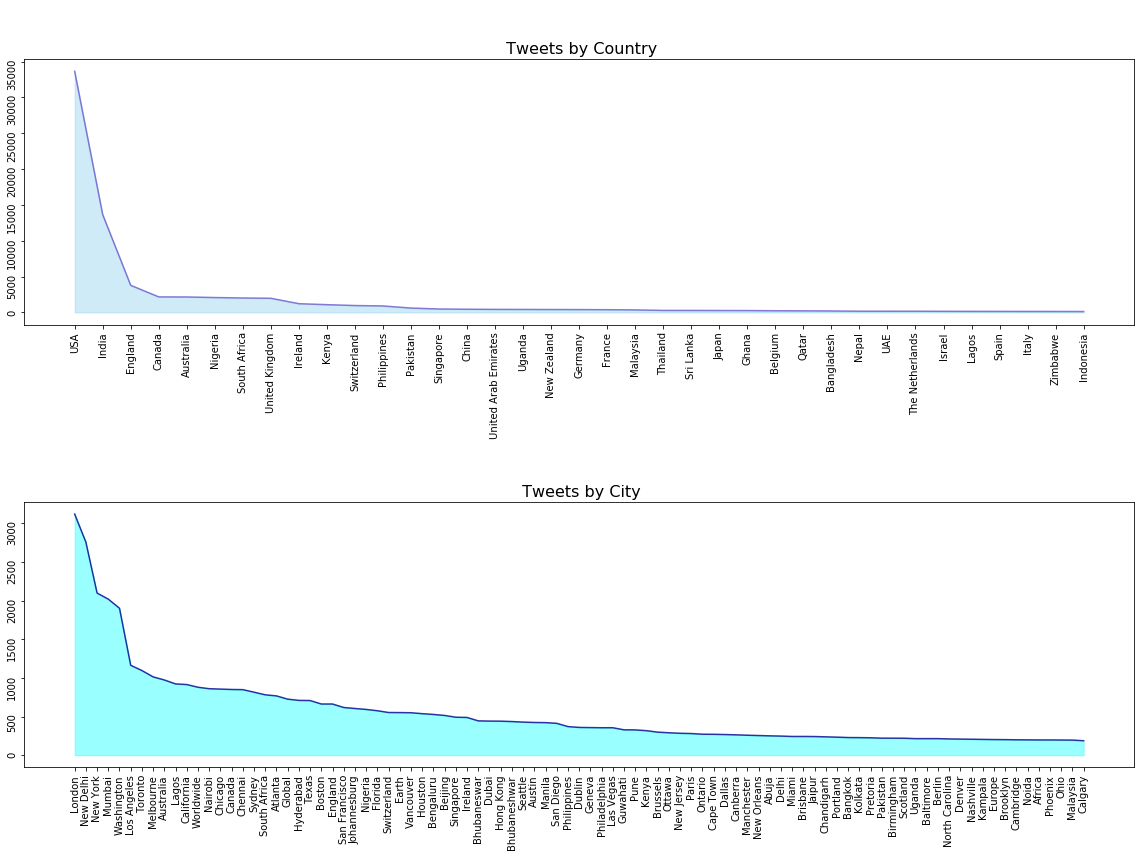

In [29]:
# Tweets trend by Country and City
fig, (ax1, ax2) = plt.subplots(2, 1, squeeze=True, figsize=(16,12))

ax1.fill_between(top100_count.country, top100_count['# of tweets'], color="skyblue", alpha=0.4)
ax1.plot(top100_count.country, top100_count['# of tweets'], color="Slateblue", alpha=0.8)
ax1.set_title("\n\n Tweets by Country", fontsize=16)

ax2.fill_between(top100_city.city, top100_city['# of tweets'],  color="aqua", alpha=0.4)
ax2.plot(top100_city.city, top100_city['# of tweets'], color="darkblue", alpha=0.8)
ax2.set_title("\n\n Tweets by City", fontsize=16)

for ax in fig.axes:
    ax.tick_params(labelrotation=90)
    
fig.tight_layout()
fig.show()

In [30]:
# Create a heatmap using folium
def color(magnitude):
    if magnitude>=2000:
        col='red'
    elif (magnitude>=500 and magnitude<2000):
        col='beige'
    elif magnitude<500:
        col='green'
    return col

In [31]:
def generateBaseMap(input_type,df,default_location=[40.693943, -73.985880], default_zoom_start=2):
    """
    Function to generate the heatmap

    Attributes
    ----------
    input_type : str
        Pass 'country' or 'city' to generate the respective heatmap
    df : str
        Name of the dataframe having the country/city coordinates and other details
    default_location : int
        Pass the default location for the displayed heatmap
    default_zoom_start: int
        Pass the default zoom for the displayed heatmap
         Methods
    -------
        Returns the base_map
    """
        
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)
    
    HeatMap(data=df[['lat','long']].values.tolist(),radius=20,max_zoom=13).add_to(base_map)
    for lat,lan,tweet,name in zip(df['lat'],df['long'],df['# of tweets'],df.iloc[:,0]): 
        # Marker() takes location coordinates as a list as an argument 
        folium.Marker(location=[lat,lan],popup = [name,tweet], 
                      icon= folium.Icon(color=color(tweet), 
                      icon_color='white', icon='twitter', prefix='fa')).add_to(marker_cluster)
        #specify the min and max values of your data
    min, max = df['# of tweets'].min(), df['# of tweets'].max()
    colormap = cm.LinearColormap(colors=['green','beige','red'], vmin=min,vmax=max)
   
    colormap.caption = input_type.title() +' distribution of COVID-19 tweets'
    colormap.add_to(base_map)
    return base_map

In [32]:
generateBaseMap('country',top100_count)

In [33]:
generateBaseMap('city',top100_city)

<p>In the heatmaps above, we can see a high concentration in regions with higher tweets. As we zoom in the heatmap, we see the number of tweets for each country and city. The color (red,yellow,green) of icon tells the intensity of tweets from high to low and as we hover over each icon, we see the name of country/ city and it's number of tweets.¶</p>

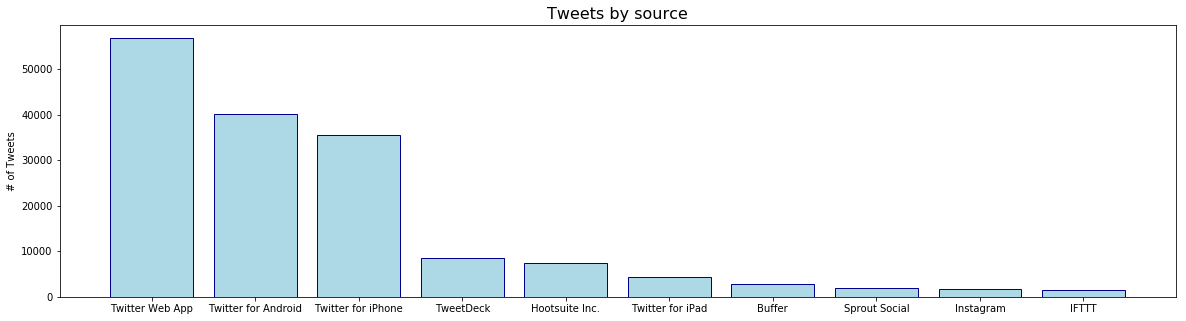

In [34]:
# Compare the tweet source
top10_source = tweets.source.value_counts().nlargest(10)
fig = plt.figure(figsize = (20,5))
plt.bar(top10_source.index, top10_source.values, color="lightblue", edgecolor="darkblue")
plt.ylabel('# of Tweets')
plt.title("Tweets by source", fontsize=16);

<p>32% of people have tweeted using the Web App, closely followed by Android users with 22%, and iPhone users with 20%</p>

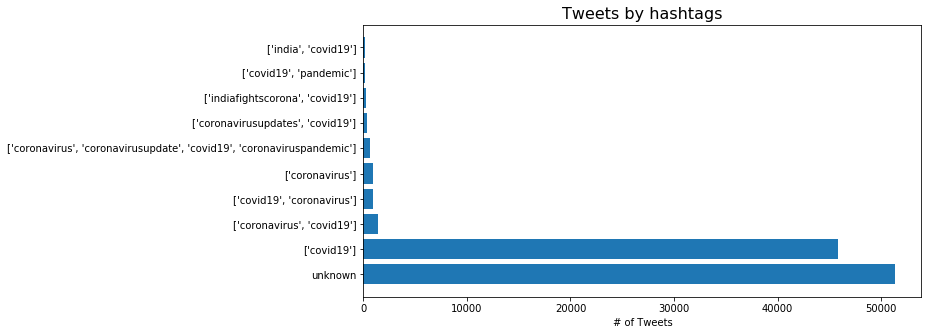

In [35]:
# Most trended hashtags
top10_hashtags = tweets.hashtags.str.lower().value_counts().nlargest(10)
# initiate the figure with it's size
fig = plt.figure(figsize = (10,5))
plt.barh(top10_hashtags.index, top10_hashtags.values)
plt.xlabel('# of Tweets')
plt.title("Tweets by hashtags", fontsize=16);

<p>As expected, ~70% of the tweets mention either covid19 or coronavirus as the hastag.</p>

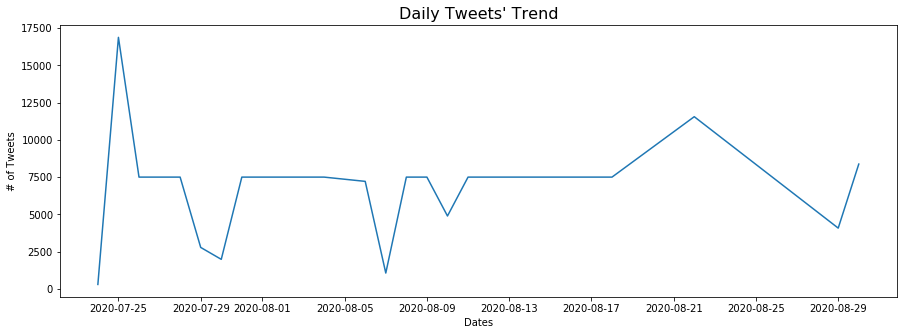

In [36]:
# Daily tweet trend
daily_tweets = tweets.groupby(['date_ext'])['text'].count()

fig = plt.figure(figsize = (15,5))
plt.plot(daily_tweets.index,daily_tweets.values)
plt.title('Daily Tweets\' Trend', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('# of Tweets')
plt.show()

<p>Notice: spike in number of tweets in the last week of July.</p>

<h1>Sentiment of Tweets </h1>

In [37]:
# Convert everything other than a-z, A-Z, 0-9 to space and remove the link from tweets
tweets['clean_tweet'] = tweets['text'].apply(lambda x: re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x))


In [40]:
def createWordCloud(input_type, text):
    """
    Function to generate the wordcloud

    Attributes
    ----------
    input_type : str
        Pass 'words'or 'entities' to update the chart title based on the text passed
    text : str
        Name of the string text to make the wordcloud
    
    Methods
    -------
        Returns the wordcloud
    """
    wordcloud = WordCloud(width = 1000, height = 600, 
                      #colormap = 'Paired',
                      background_color ='white',
                      collocations = False,
                      stopwords=stop_words
                     ).generate(text)
    plt.figure(figsize = (12, 12), facecolor = None)
    plt.title("Most common "+ input_type +" in the tweets \n", fontsize=20, color='Black')
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

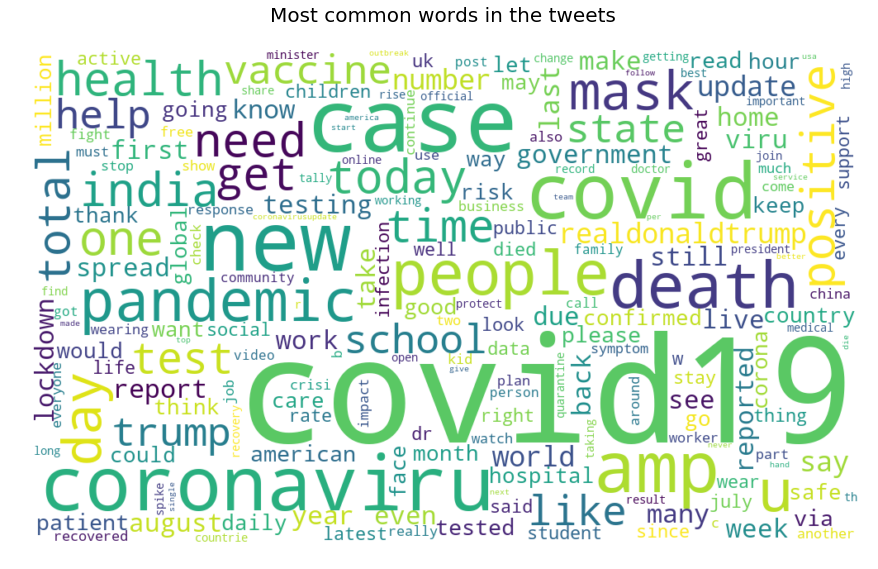

In [41]:
# Create a wordcloud for most popular words in tweets
text = '' 
stop_words = set(stopwords.words("english"))
for row in tweets['clean_tweet']:
    # typecaste each row to string and split it to get tokens
    tokens = str(row).split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    text += " ".join(tokens)+" "

createWordCloud("words",text)

<h3> Caculate Sentiment </h3>

In [42]:
# We are using Compound score to detect the tweet sentiment which is a metric that calculates the sum of
# all the lexicon ratings which have been normalized between 
# -1(most extreme negative) and +1 (most extreme positive)
# positive: (compound score >= 0.05), negative : (compound score <= -0.05), neutral otherwise
sid = SentimentIntensityAnalyzer()
for index, row in tqdm(tweets.iterrows()): #tqdm 
    ss = sid.polarity_scores(row['clean_tweet'])
    if ss['compound'] >= 0.05 : 
        tweets.at[index,'sentiment'] = "Positive"
    elif ss['compound'] <= - 0.05 : 
        tweets.at[index,'sentiment'] = "Negative"
    else : 
        tweets.at[index,'sentiment'] = "Neutral"

179108it [01:26, 2073.03it/s]


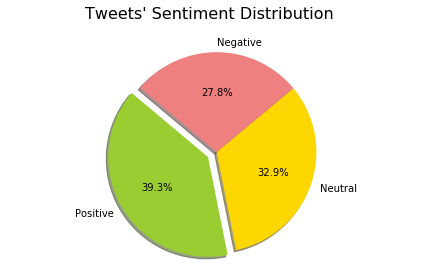

In [43]:
# Show distribution of tweet sentiments
sentiment_dist = tweets.sentiment.value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode= (0.1,0,0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets\' Sentiment Distribution \n", fontsize=16, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [44]:
# Function to filter top 10 tweets by sentiment
def top10AccountsBySentiment(sentiment):
    df = tweets.query("sentiment==@sentiment")
    top10 = df.groupby(by=["user_name"])['sentiment'].count().sort_values(ascending=False)[:10]
    return(top10)


C:\Users\sara\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


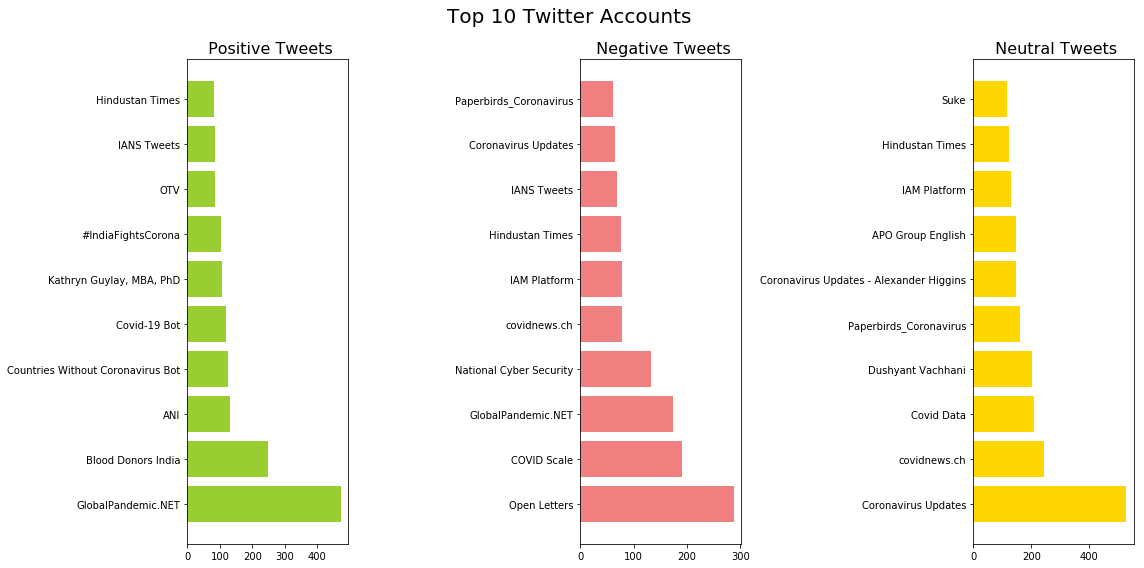

In [45]:

# Top 10 tweets by each sentiment
top10_pos = top10AccountsBySentiment("Positive")
top10_neg = top10AccountsBySentiment("Negative")
top10_neu = top10AccountsBySentiment("Neutral")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, figsize=(16,8))
fig.suptitle('Top 10 Twitter Accounts \n', fontsize=20)

ax1.barh(top10_pos.index, top10_pos.values, color='yellowgreen')
ax1.set_title("\n\n Positive Tweets", fontsize=16)

ax2.barh(top10_neg.index, top10_neg.values, color='lightcoral')
ax2.set_title("\n\n Negative Tweets", fontsize=16)

ax3.barh(top10_neu.index, top10_neu.values, color='gold')
ax3.set_title("\n\n Neutral Tweets", fontsize=16);

fig.tight_layout()
fig.show()
